# Feature Extraction

In [1]:
import os

DATASET_NAME = "drsprg"
DATA_BASE_DIR = f"../data/processed/{DATASET_NAME}/"
IMAGES_DIR = os.path.join(DATA_BASE_DIR, "jpgs/")
DATASET = os.path.join(DATA_BASE_DIR, "data_list_export_120217.xlsx")
AVG_BLURRED_IMAGES = os.path.join(DATA_BASE_DIR, "artifacts/avg_blurred_images.pkl")
PREP_STUDIES = os.path.join(DATA_BASE_DIR, "artifacts/prep_studies.pkl")

In [29]:
import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from tqdm import tqdm
from pathlib import Path

## Local Binary Patterns

In [3]:
avg_blurred_images = joblib.load(AVG_BLURRED_IMAGES)
prep_studies = joblib.load(PREP_STUDIES)

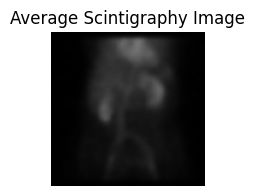

In [4]:
avg_img = avg_blurred_images[0][0]
plt.figure(figsize=(3, 2))
plt.imshow(avg_img)
plt.title("Average Scintigraphy Image")
plt.axis("off")
plt.savefig("../images/averaging.pdf")
plt.show()

Feature vector length 108


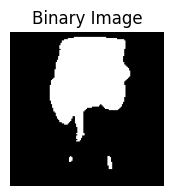

In [37]:
def extract_features__lbp(images: list, radius=1, sampling_pixels=106):
    def get_lbp(img):
        lbp = skimage.feature.local_binary_pattern(
            img, sampling_pixels, radius, method="uniform"
        )
        return (img, lbp)

    def get_hist(img_lbp):
        img, lbp = img_lbp
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, sampling_pixels + 3),
            range=(0, sampling_pixels + 2),
        )
        hist = hist.astype("float")
        hist /= hist.sum() + 1e-6
        return img, hist

    def cvt(img):
        if len(img.shape) > 2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        i_min = np.min(img)
        i_max = np.max(img)
        if i_max - i_min != 0:
            img = (img - i_min) / (i_max - i_min)

        img = img.astype(np.uint8)

        return img

    cvt_imgs = [cvt(img) for img in images]
    imgs_lbps = [get_lbp(img) for img in cvt_imgs]
    imgs_hists = [get_hist(img_lbp) for img_lbp in imgs_lbps]
    return imgs_hists


imgs_hists = extract_features__lbp([avg_img])[0]
print("Feature vector length", len(imgs_hists[1]))
plt.figure(figsize=(3, 2))
plt.imshow(imgs_hists[0], cmap="gray")
plt.title("Binary Image")
plt.axis("off")
plt.savefig("../images/binarization.pdf")
plt.show()

In [35]:
def ext_features_from_study_images(prep_studies):
    lbp_dataset = []
    for study in tqdm(prep_studies):
        label = study[1]
        imgs = [img[0] for img in study[0]]
        imgs_hists = extract_features__lbp(imgs)
        hists = [img_hist[1] for img_hist in imgs_hists]
        features = []
        for h in hists:
            features.extend(h)
        assert len(features) == 1620
        lbp_dataset.append((features, label))
    return lbp_dataset

lbp_dataset = ext_features_from_study_images(prep_studies)

100%|██████████| 102/102 [00:44<00:00,  2.31it/s]


In [36]:
save_to = Path(os.path.join(DATA_BASE_DIR, "artifacts/lbp_dataset.pkl"))
save_to.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(lbp_dataset, str(save_to))

['../data/processed/drsprg/artifacts/lbp_dataset.pkl']